In [23]:
!pip install langgraph langsmith langchain langchain_groq langchain_community

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [24]:
!pip install arxiv wikipedia

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [25]:
from typing import Annotated
from typing_extensions import TypedDict

In [26]:
## Working With Tools

from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

## Arxiv And Wikipedia tools
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
arxiv_tool=ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=300)
wiki_tool=WikipediaQueryRun(api_wrapper=api_wrapper)

In [27]:
wiki_tool.invoke("who is Nicola Tesla?")

'Page: Nikola Tesla\nSummary: Nikola Tesla (; Serbian Cyrillic: Никола Тесла [nǐkola têsla]; 10 July 1856 – 7 January 1943) was a Serbian-American engineer, futurist, and inventor. He is known for his contributions to the design of the modern alternating current (AC) electricity supply system.\nBorn an'

In [28]:
arxiv_tool.invoke("Defination of Large Language Model")

'Published: 2024-06-24\nTitle: Large Vocabulary Size Improves Large Language Models\nAuthors: Sho Takase, Ryokan Ri, Shun Kiyono, Takuya Kato\nSummary: This paper empirically investigates the relationship between subword\nvocabulary size and the performance of large language models (LLMs) to provide\ninsi'

In [29]:
tools=[wiki_tool]

In [30]:
## Langgraph Application
from langgraph.graph.message import add_messages
class State(TypedDict):
  messages:Annotated[list,add_messages]

In [31]:
from langgraph.graph import StateGraph,START,END

In [32]:
graph_builder= StateGraph(State)


In [33]:
from langchain_groq import ChatGroq

In [34]:
import os
from langchain_groq import ChatGroq
from dotenv import load_dotenv

load_dotenv()

groq_api_key = os.getenv("GROQ_API_KEY")  # Ensure this is a string


In [35]:
llm = ChatGroq(api_key=groq_api_key, model_name="deepseek-r1-distill-llama-70b")

# print(llm)
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x767ac11f3310>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x767ac11f3c40>, model_name='deepseek-r1-distill-llama-70b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [36]:
llm_with_tools=llm.bind_tools(tools=tools)

In [37]:
def chatbot(state:State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [38]:
from langgraph.prebuilt import ToolNode,tools_condition

In [39]:
graph_builder.add_node("chatbot",chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START,"chatbot")


In [40]:
graph=graph_builder.compile()

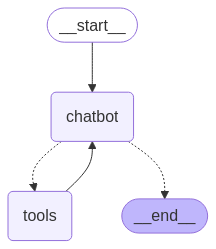

In [41]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [42]:
user_input="Hi there!, My name is Fahad"

events=graph.stream(
     {"messages": [("user", user_input)]},stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there!, My name is Fahad
================================== Ai Message ==================================

Hello Fahad! How can I assist you today? If you have any questions or need help with something, feel free to ask.


In [43]:
user_input = "what is RLHF."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]},stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is RLHF.
================================== Ai Message ==================================

RLHF stands for **Reinforcement Learning from Human Feedback**. It's a method used in training AI models to align their outputs with human preferences. Here's how it works:

1. **Human Feedback Collection**: Humans evaluate and rank the outputs of a model based on quality, relevance, or other criteria.
2. **Reward Model Training**: A reward model is trained to predict the rankings provided by humans. This model learns to distinguish between "good" and "bad" outputs.
3. **Reinforcement Learning**: The main AI model is fine-tuned using reinforcement learning, where it aims to maximize the reward (i.e., produce outputs that align with human preferences).

This approach is widely used in fine-tuning large language models to improve their performance in generating human-like and contextually appropriate responses.


In [44]:
# Import required modules
from langchain_core.messages import AIMessage, HumanMessage

# Initialize chat history
chat_history = []

# Start the chat loop
while True:
    user_input = input("You: ")  # Take user input

    if user_input.lower() in ["exit", "quit", "bye"]:
        print("Chatbot: Goodbye!")
        break  # Exit the loop if the user wants to quit

    # Append the user's message to the chat history
    chat_history.append(HumanMessage(user_input))

    # Generate a response
    events = graph.stream({"messages": chat_history}, stream_mode="values")

    # Collect chatbot response
    chatbot_response = ""
    for event in events:
        # Get the chatbot response, ignoring irrelevant content like "Page" or summaries
        content = event["messages"][-1].content
        if "Page" not in content and len(content.strip()) > 0:
            chatbot_response += content.strip()

    # Ensure that chatbot response is valid and does not contain "Page" or summaries
    if chatbot_response:
        # Print the dialogue in the correct format
        print(f"You: {user_input}")
        print(f"Chatbot: {chatbot_response}")
    else:
        print("Chatbot: I'm sorry, I couldn't find a response to that.")

    # Append AI response to chat history to maintain context
    chat_history.append(AIMessage(chatbot_response))


You: What is LangChain?
Chatbot: What is LangChain?LangChain is a software framework designed to facilitate the integration of large language models (LLMs) into applications. Its primary purpose is to enable developers to easily incorporate the capabilities of LLMs into their projects, enhancing tasks such as document analysis, natural language processing, and more. LangChain's use cases largely overlap with those of language models in general, making it a versatile tool for a wide range of applications.
You: What about LangGraph?
Chatbot: What about LangGraph?LangGraph doesn't seem to be a widely recognized or established tool or framework in the context of large language models or related technologies as of my knowledge cutoff in July 2024. It's possible that it could be a niche tool, a new development, or something specific to a particular use case or organization that isn't widely known.

If you have more context or if LangGraph is related to a specific application or project, feel